In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from skimage.io import imshow
#from sklearn.model_selection import train_test_split

#import tensorflow as tf

import keras

from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
#making sure GPU is in use 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 190749453546973910
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11285289370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3836097083284164702
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
# Set some parameters
in_height = 64
in_width = 64
out_height = 256
out_width = 256
color_dim = 3
path_in = '/home/Matthew/image-super-resolution/data/imagenet/10k/res64noisy/'
path_out = '/home/Matthew/image-super-resolution/data/imagenet/10k/res256/'

In [4]:
#todo: add random shuffle 
#, seed = 0

def load_images(path_in, path_out, test_size):
    images = next(os.walk(path_in))[2] #oswalk is a generator 
    num_images = len(images)

    splitIdx = int(test_size * num_images)
    testSize = int((test_size) * num_images)
    trainSize = int(math.ceil((1-test_size) * num_images))
    
    X_train = np.zeros((trainSize,in_height,in_width,color_dim), dtype=np.float32)
    X_test = np.zeros((testSize,in_height,in_width,color_dim), dtype=np.float32)
    y_train = np.zeros((trainSize,out_height,out_width,color_dim), dtype=np.float32)
    y_test  = np.zeros((testSize,out_height,out_width,color_dim), dtype=np.float32)

    trainIdx = 0
    testIdx = 0
    for idx, image in enumerate(images):
        image_in_path = os.path.join(path_in,image)
        image_out_path = os.path.join(path_out,image)

        image_in_raw =  load_img(image_in_path, grayscale=False)
        image_out_raw = load_img(image_out_path, grayscale=False)

        #converts image to keras preprocessing image, then divide by 255 to un-invert the images
        image_in = (img_to_array(image_in_raw)).squeeze() / 255 
        image_out = (img_to_array(image_out_raw)).squeeze() / 255          
 
        try:
            if (idx % 1000 == 0):
                print("Stage " + str(idx))
        
            if (idx >= splitIdx):
                #print("trainIdx " + str(trainIdx))
                X_train[trainIdx] = image_in
                y_train[trainIdx] = image_out
                
                trainIdx+=1
            else:
                #print("testIdx " + str(testIdx))
                X_test[testIdx] = image_in
                y_test[testIdx] = image_out
                
                testIdx+=1
                
        except Exception as e: 
            print("\nERROR!!!!")
            print(image_in.shape)
            print(trainIdx)
            
            print(image_out.shape)
            print(testIdx)
            
            print("id "+str(idx))
            print(image_in_path)
            print(e)
           
            print("\n")
            
    return X_train,X_test,y_train,y_test

In [5]:
X_train,X_test,y_train,y_test = load_images(path_in, path_out, .2)

Stage 0
Stage 1000
Stage 2000
Stage 3000
Stage 4000
Stage 5000
Stage 6000
Stage 7000
Stage 8000
Stage 9000


In [6]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from keras.optimizers import RMSprop

In [7]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import  BatchNormalization, Activation, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [8]:
#padding output size: see http://cs231n.github.io/convolutional-networks/
# output = (W−F+2P)/S+1   w- input size, f-kernel size, p-padding size 

In [9]:
#model = Sequential()
#inputShape = (in_height, in_width, color_dim)
#model.add(UpSampling2D((4,4),input_shape=inputShape))
#model.add(Conv2D(32, (9, 9), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 32
#model.add(Activation("relu"))
#model.add(Conv2D(16, (7, 7), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 16
#model.add(Activation("relu"))
#model.add(Conv2D(16, (7, 7), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 16
#model.add(Activation("relu"))
#model.add(Conv2D(color_dim, (5, 5), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 3
#model.add(Activation("sigmoid"))

In [10]:
# https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [12]:
def create_network(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    #c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(input_img)
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), padding='same') (c7)
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*1, (3, 3), padding='same') (c8)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(color_dim, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
'''def create_network(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    #c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(input_img)
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), padding='same') (c7)
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), padding='same') (c8)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(color_dim, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model'''

"def create_network(input_img, n_filters=16, dropout=0.5, batchnorm=True):\n    # contracting path\n    #c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)\n    \n    \n    # expansive path\n    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(input_img)\n    u6 = Dropout(dropout)(u6)\n    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)\n\n    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)\n    u7 = Dropout(dropout)(u7)\n    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)\n\n    u8 = Conv2DTranspose(n_filters*2, (3, 3), padding='same') (c7)\n    u8 = Dropout(dropout)(u8)\n    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)\n\n    u9 = Conv2DTranspose(n_filters*1, (3, 3), padding='same') (c8)\n    u9 = Dropout(dropout)(u9)\n    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=

In [14]:
input_img = Input((in_height, in_width, color_dim), name='img')
model = create_network(input_img, n_filters=8, dropout=0.05, batchnorm=True)

In [15]:
model.compile(loss='mean_squared_error', optimizer = RMSprop(),metrics=['accuracy'])

In [16]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 64)      1792      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
__________

In [17]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [19]:
batch_size = 32
epochs = 50
trainHistory = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test),callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 267s 33ms/step - loss: 0.0276 - acc: 0.5885 - val_loss: 0.0236 - val_acc: 0.6204

Epoch 00001: val_loss improved from inf to 0.02357, saving model to model-tgs-salt.h5
Epoch 2/50
8000/8000 [==============================] - 261s 33ms/step - loss: 0.0108 - acc: 0.6163 - val_loss: 0.0107 - val_acc: 0.6252

Epoch 00002: val_loss improved from 0.02357 to 0.01069, saving model to model-tgs-salt.h5
Epoch 3/50
8000/8000 [==============================] - 261s 33ms/step - loss: 0.0098 - acc: 0.6462 - val_loss: 0.0139 - val_acc: 0.5929

Epoch 00003: val_loss did not improve from 0.01069
Epoch 4/50
8000/8000 [==============================] - 261s 33ms/step - loss: 0.0092 - acc: 0.6745 - val_loss: 0.0104 - val_acc: 0.7068

Epoch 00004: val_loss improved from 0.01069 to 0.01036, saving model to model-tgs-salt.h5
Epoch 5/50
8000/8000 [==============================] - 261s 33ms/step - loss: 0.00

8000/8000 [==============================] - 262s 33ms/step - loss: 0.0069 - acc: 0.7262 - val_loss: 0.0065 - val_acc: 0.7559

Epoch 00039: val_loss did not improve from 0.00647
Epoch 40/50
8000/8000 [==============================] - 262s 33ms/step - loss: 0.0069 - acc: 0.7255 - val_loss: 0.0065 - val_acc: 0.7542

Epoch 00040: val_loss did not improve from 0.00647
Epoch 41/50
8000/8000 [==============================] - 262s 33ms/step - loss: 0.0069 - acc: 0.7246 - val_loss: 0.0065 - val_acc: 0.7536

Epoch 00041: val_loss did not improve from 0.00647
Epoch 42/50
8000/8000 [==============================] - 263s 33ms/step - loss: 0.0069 - acc: 0.7259 - val_loss: 0.0065 - val_acc: 0.7562

Epoch 00042: val_loss did not improve from 0.00647
Epoch 43/50
8000/8000 [==============================] - 263s 33ms/step - loss: 0.0069 - acc: 0.7260 - val_loss: 0.0065 - val_acc: 0.7539

Epoch 00043: val_loss did not improve from 0.00647
Epoch 44/50
8000/8000 [==============================] - 263s 

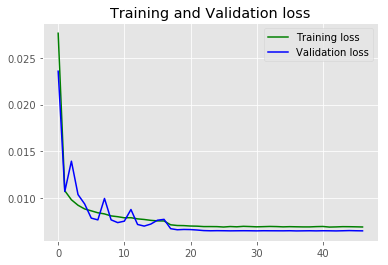

In [25]:
loss = trainHistory.history['loss']
val_loss = trainHistory.history['val_loss']
epochsRange = range(len(trainHistory.history['loss']))
plt.figure()
plt.plot(epochsRange, loss, label='Training loss',color='g')
plt.plot(epochsRange, val_loss, label='Validation loss',color='b')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

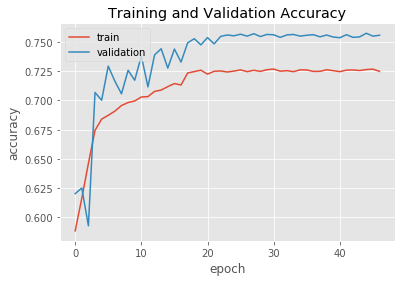

In [26]:
plt.plot(trainHistory.history['acc'])
plt.plot(trainHistory.history['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
print(trainHistory.history.keys())

dict_keys(['val_loss', 'val_acc', 'acc', 'lr', 'loss'])


In [28]:
pred = model.predict(X_test)

Test Images


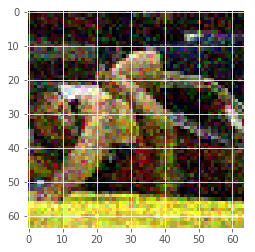

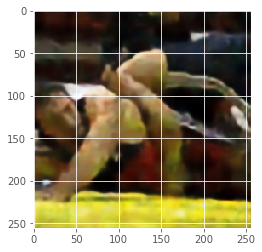

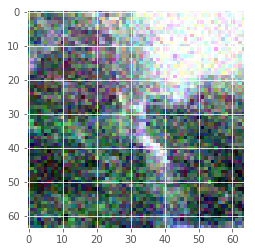

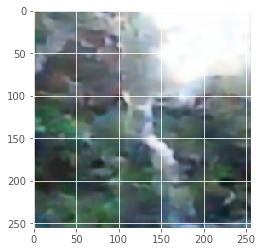

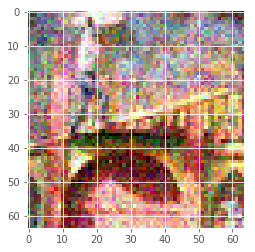

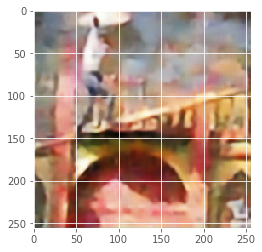

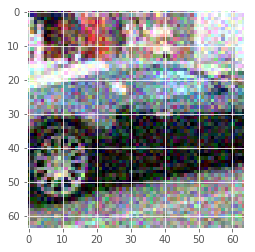

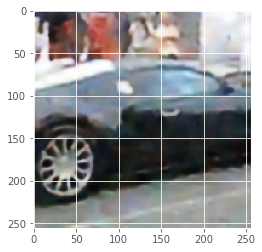

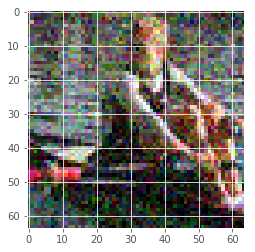

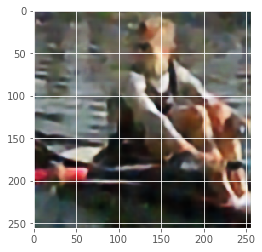

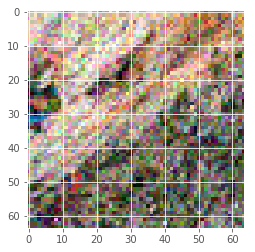

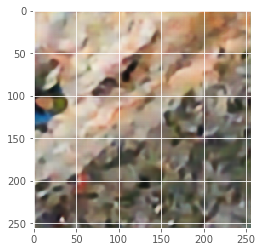

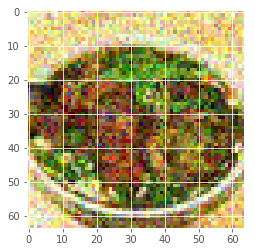

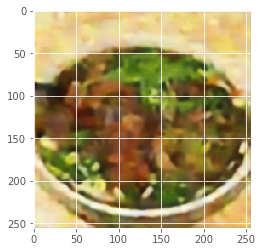

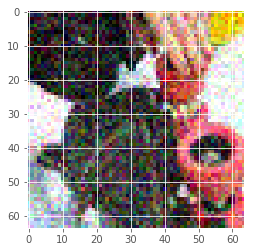

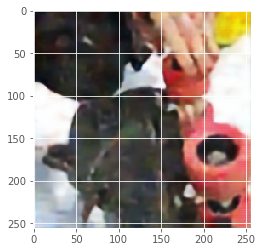

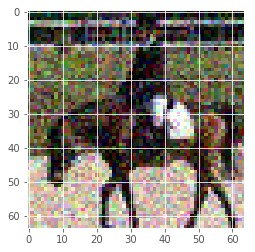

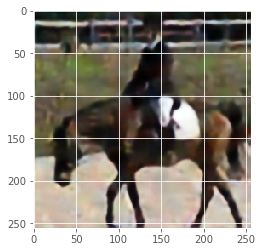

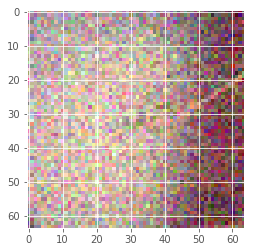

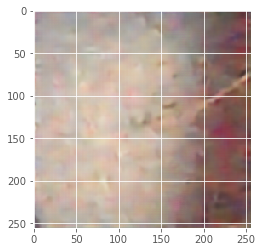

In [29]:
#plt.figure(figsize=(256, 256))
print("Test Images")

for i in range(10):
    #plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i])
    plt.show()
    plt.imshow(pred[i])
    #plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
    plt.show()

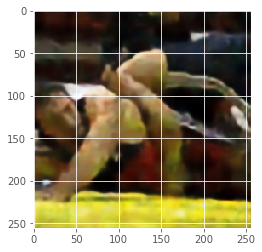

In [30]:
plt.imshow(pred[0])  